# Global Warming

## HadCRUT4's temperature anomalies

In [1]:
# Needed Julia packages:
#   DelimitedFiles: for readdlm() needed for importing data
#   Statistics: for mean()
#   FFTW: for fft()
#   Plots: for drawing data with plot()
using DelimitedFiles, Statistics, FFTW, Plots

In [2]:
# Read raw temperature anomalies (one by month from 1850).
# HadCRUT4: temperature matrix year-month, 1st column = year
# Force converting all data to Float
M = convert(Matrix{Float64}, readdlm("data/HadCRUT4.txt", ' ', Any, '\n'))

# D: years, T: averaged temperature over each year. h: HadCRUT4
Dh, Th = convert(Vector{Int64}, M[:,1]), mean(M[:,2:end]; dims=2)[:];

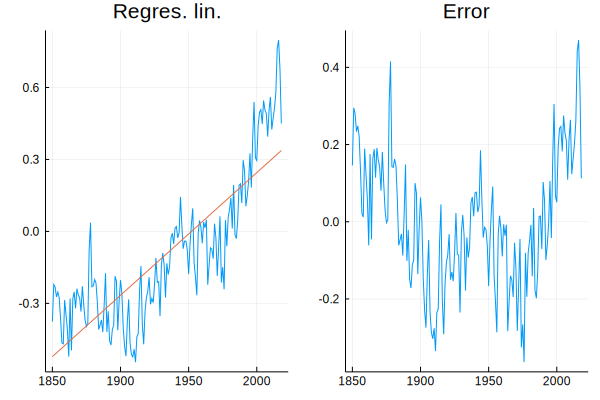

In [3]:
# Linear regression
linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y

# Get the linear regression of temperatures over years
b, a = linreg(Dh, Th)
regTh = a .* Dh .+ b

plot(plot(Dh, [Th regTh], title="Regres. lin.", leg=false),
     plot(Dh, Th .- regTh, title="Error", leg=false),
     layout=2)

In [4]:
# Filter function based on FFT
# r: range of frequencies we want to preserve:
#   preserve low +ve frequencies [1:r+1]
#   preserve low -ve frequencies [end-r+1:end]
# Unpreserved frequencies are zero'ed.
function filtFFT(S::Vector{Float64}, r::Int64)
    F = fft(S)
    F[r+1:end-r+1] .= 0.0
    real(ifft(F))
end

filtFFT (generic function with 1 method)

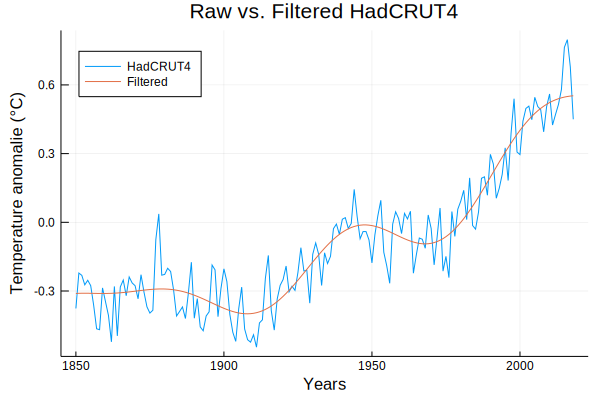

In [5]:
# TODO: mettre un scroller pour le 5
# Filter the raw signal minus its linear regression. Thf: HadCRUT4 filtered temperature.
Thf = filtFFT(Th .- regTh, 4) .+ regTh

plot(Dh, [Th Thf], title = "Raw vs. Filtered HadCRUT4",
                   xlabel="Years", ylabel="Temperature anomalie (°C)", 
                   label=["HadCRUT4" "Filtered"], legend=:topleft)

## Estimated temperature based on filtered HadCRUT4 values

Let suppose a new cycle will apear on years 2090 and where the ratio of the amplitude between the third cycle (year 2020) and the second cycle (year 1950) is the same than the second cycle and the first (year 1880). This supposition comes from:
- the human kind economy will keep increasing with the same current exponential rate;
- the temperature raise is mainly due by the human kind;

we have:

In [6]:
Rc3 = Th[2019 - Dh[1]] # Optimum of 3th cycle
Rc2 = Th[1950 - Dh[1]] # Optimum of 2nd cycle
Rc1 = Th[1880 - Dh[1]] # Optimum of 1st cycle

Rc32 = abs(Rc3 - Rc2)
Rc21 = abs(Rc2 - Rc1)
Estim = Rc32 * (Rc32 / Rc21)

1.8061415707853916

**Estimated Temperature in 2090: +1.8°C**

## Estimated temperature based on filtered GIEC's model

In [45]:
M = convert(Matrix{Float64}, readdlm("data/AR5.txt", ' ', Any, '\n'));
Dg, Tg = M[:,1], M[:,2]

# We halt the model to Year 2025
Dend = Int64(2025 - Dg[1])

# Offset between GIEC value and HadCRUT4
Toff = 0.56
Tg = Tg .+ Toff

# Linear regression of the GIEC model
b, a = linreg(Dg, Tg)
regTg = a .* Dg .+ b

# Filtered GIEC model
Tgf = filtFFT(Tg.- regTg, 6) .+ regTg;

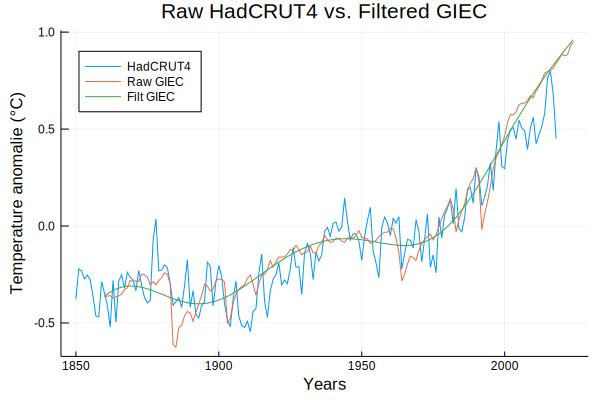

In [46]:
plot(Dh, Th, title="Raw HadCRUT4 vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="HadCRUT4", legend=:topleft)

plot!(Dg[1:Dend], Tg[1:Dend], label="Raw GIEC")
plot!(Dg[1:Dend], Tgf[1:Dend], label="Filt GIEC")

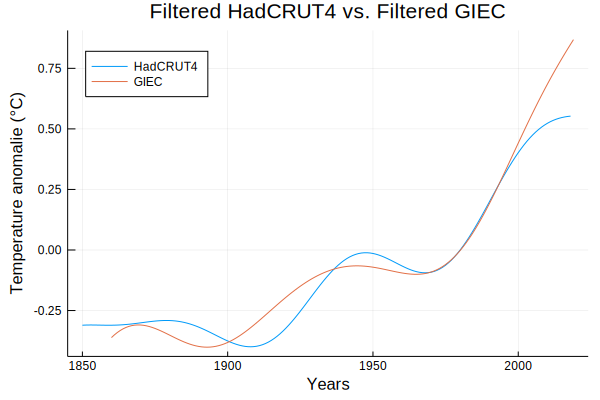

In [43]:
# Filtered GIEC model versus filtered HadCRUT4
plot(Dh, Thf, title="Filtered HadCRUT4 vs. Filtered GIEC",
              xlabel="Years", ylabel="Temperature anomalie (°C)", 
              label="HadCRUT4", legend=:topleft)

plot!(Dg[1:Dend], Tgf[1:Dend], label="GIEC")

In [44]:
[Dg[end] Tgf[end] - Toff]

1×2 Array{Float64,2}:
 2100.0  2.17679

**Estimated Temperature in 2100: +2.1C**

## Ljungqvist's Temperature Reconstruction

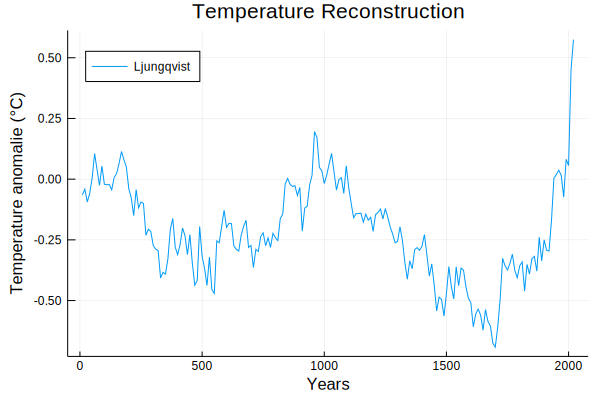

In [11]:
# Ljungqvist dataset:
#   1st column: temporal slice (ie 09 means from year to year 9).
#   2nd column: averaged temperature over 10 years (from year 0 to 2000).
M = convert(Matrix{Float64}, readdlm("data/ljung.txt", ' ', Any, '\n'));

# TODO faire depuis 1850 + offset(hadcrut, Ljungqvist)
# Ljungqvist extended for years 2000 -- 2019 by adding HadCRUT4 means
y2k, y2k10 = Int64(2000 - Dh[1]), Int64(2010 - Dh[1])
Dl = [1:size(M,1) + 2;] .* 10
Tl = [M[:,2]; mean(Th[y2k:y2k10]); mean(Th[y2k10:end])]
plot(Dl, Tl, title="Temperature Reconstruction", xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Ljungqvist", legend=:topleft)

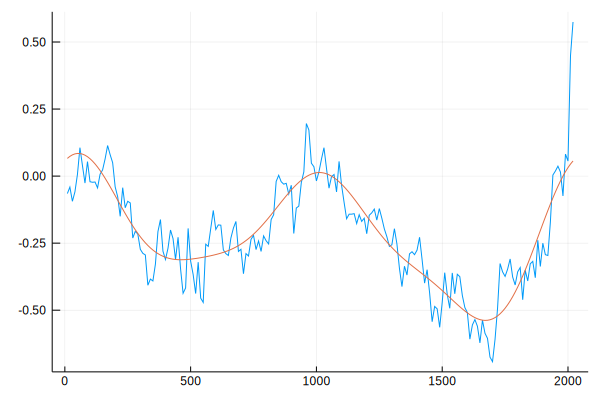

In [12]:
# b, a = linreg(Dl, Tl)
# regTl = a .* Dl .+ b
# Tlf = filtFFT(Tl .- regTl, 5) .+ regTl
Tlf = filtFFT(Tl, 5)
plot(Dl, [Tl Tlf], leg=false)